# Appendix A.2 MODIS Data Preparation code

In [2]:
import datetime as dt
from pathlib import Path
import math
import os
import sqlite3
import json
import geopandas as gpd
import pygeos
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from functools import partial


from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [3]:
## Map file

In [4]:
USA = gpd.read_file("Data/County/cb_2018_us_county_500k.shp")
USA.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


#### 2b. Load the dataset 2: NASA Active Fire Data - https://earthdata.nasa.gov/

In [5]:
current_dir = Path(os.getcwd()).absolute()

In [6]:
old_nasa_df = pd.read_csv('Data/fire_archive_M6_156000.csv') # archive data 
new_nasa_df = pd.read_csv('Data/fire_nrt_M6_156000.csv') # new data 

nasa_df = pd.concat([old_nasa_df, new_nasa_df]) #concatenate old and new data
print(nasa_df.shape)
nasa_df.tail(4)

(1248606, 15)


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
66330,36.293,-118.664,329.6,1.1,1.0,2020-09-27,1855,Terra,MODIS,66,6.0NRT,297.3,24.9,D,NaN
66331,40.043,-123.080,337.5,1.2,1.1,2020-09-27,1855,Terra,MODIS,88,6.0NRT,302.2,40.3,D,NaN
66332,45.726,-118.308,305.5,1.0,1.0,2020-09-27,1855,Terra,MODIS,30,6.0NRT,293.1,6.5,D,NaN
66333,37.262,-119.443,319.4,1.0,1.0,2020-09-27,1855,Terra,MODIS,65,6.0NRT,300.6,9.9,D,NaN


### Data Preliminary Analysis

In [8]:
# check for missing value
def percentMissing(df):
    
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    
    # % of missing data
    for col in df.columns:
        # create missing indicator for features with missing data
        missing = df[col].isnull()
        pct_missing = np.mean(missing)*100
        #if pct_missing >60:
        print('{} - {}%'.format(col, round(pct_missing)))
        num_missing = np.sum(missing)

In [9]:
# Checking data type
def Datatype(df):
    # shape and data types of the data
    print("There are {} rows and {} columns".format(df.shape[0], df.shape[1]))
    print(df.dtypes)

    # select numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    print(numeric_cols)

    # select non numeric columns
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    non_numeric_cols = df_non_numeric.columns.values
    print(non_numeric_cols)

## Data Exploration: MODIS Collection 6 Active Fire Data

In [10]:
Datatype(nasa_df)

There are 1248606 rows and 15 columns
latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence      int64
version        object
bright_t31    float64
frp           float64
daynight       object
type          float64
dtype: object
['latitude' 'longitude' 'brightness' 'scan' 'track' 'acq_time'
 'confidence' 'bright_t31' 'frp' 'type']
['acq_date' 'satellite' 'instrument' 'version' 'daynight']


In [11]:
# Adding new month and day variables
nasa_df['acq_date'] = pd.to_datetime(nasa_df['acq_date'])
nasa_df.rename(columns={"acq_date":"ActiveDate"}, inplace=True)

nasa_df['ActiveYear'] = nasa_df['ActiveDate'].dt.year
nasa_df['ActiveMonth'] = nasa_df['ActiveDate'].dt.month
nasa_df['ActiveDay'] = nasa_df['ActiveDate'].dt.day

In [12]:
#binning method for confidence of fire.
bins = [0, 30,80,100]
labels = ['low', 'nominal','high']
nasa_df['ConfidenceBinned'] = pd.cut(nasa_df['confidence'], bins=bins, labels=labels)
nasa_df['ConfidenceBinned']= nasa_df['ConfidenceBinned'].fillna('low')

In [13]:
# dropping version and instrument variable because it just tells us what version of the instrument is used.
nasa_df = nasa_df.drop(['instrument', 'version', 'acq_time'], axis = 1)
nasa_df = nasa_df.rename(columns={'brightness': 'Brightness', 'scan': 'Scan', 
                                  'track': 'Track', 'longitude': 'NasaLongitude', 
                                  'satellite': 'Satellite', 'confidence':'Confidence', 
                                  'bright_t31':'BrightT31', 'frp': 'Frp', 'daynight': 'DayNight', 
                                  'type': 'HotSpotType','latitude': 'NasaLatitude'})

nasa_df.shape

(1248606, 16)

In [14]:
nasa_df.dropna(inplace=True)

In [15]:
ca_nasa_df = nasa_df[(nasa_df['NasaLatitude']<= 42) & (nasa_df['NasaLatitude'] >= 32)]
ca_nasa_df = ca_nasa_df[(ca_nasa_df['NasaLongitude']<= -114) & (ca_nasa_df['NasaLongitude'] >= -126)]

In [16]:
x = ca_nasa_df[ca_nasa_df['NasaLatitude']<= 42]
y = ca_nasa_df[(ca_nasa_df['NasaLatitude'] >= 42) & (ca_nasa_df['NasaLatitude'] <= 47)]
y = y[y['NasaLongitude'] <=-117.1]

In [17]:
ca_nasa_df = ca_nasa_df[ca_nasa_df['ActiveYear'] >=2011]

In [18]:
ca_nasa_df.shape

(114599, 16)

In [19]:
percentMissing(ca_nasa_df)

NasaLatitude - 0%
NasaLongitude - 0%
Brightness - 0%
Scan - 0%
Track - 0%
ActiveDate - 0%
Satellite - 0%
Confidence - 0%
BrightT31 - 0%
Frp - 0%
DayNight - 0%
HotSpotType - 0%
ActiveYear - 0%
ActiveMonth - 0%
ActiveDay - 0%
ConfidenceBinned - 0%


In [20]:
# check for duplicates in coordinates
duplicate = ca_nasa_df[ca_nasa_df.duplicated(['NasaLatitude', 'NasaLongitude', 'ActiveDate'], keep = False)]
duplicate

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Satellite,Confidence,BrightT31,Frp,DayNight,HotSpotType,ActiveYear,ActiveMonth,ActiveDay,ConfidenceBinned
587108,36.8276,-118.8827,309.6,2.6,1.5,2015-08-20,Terra,78,293.2,35.1,N,0.0,2015,8,20,nominal
589099,36.8276,-118.8827,406.3,1.7,1.3,2015-08-20,Aqua,100,314.4,617.1,D,0.0,2015,8,20,high
701970,36.3855,-121.7702,306.1,3.5,1.8,2016-07-30,Terra,41,294.7,36.1,N,0.0,2016,7,30,nominal
702125,36.3855,-121.7702,373.7,1.0,1.0,2016-07-30,Terra,100,313.0,118.5,D,0.0,2016,7,30,high
982192,40.7501,-122.5168,328.5,1.1,1.0,2018-08-06,Terra,100,292.9,28.7,N,0.0,2018,8,6,high
982434,40.7501,-122.5168,321.9,1.0,1.0,2018-08-06,Aqua,100,290.9,19.3,N,0.0,2018,8,6,high


#### They are not really duplicates and got detected by two separate Satellite

In [21]:
ca_nasa_df.shape

(114599, 16)

In [22]:
# Histograms
def histogram(xaxes, yaxes, df, x, y, nrows, color):
    plt.rcParams['figure.figsize'] = (x, y)
        
    fig, axes = plt.subplots(nrows = nrows, ncols = 2)
    fig.suptitle('Distribution of Fire Pixel Attributes in West Coast Region (2011-2020)', fontsize=20)

    # draw histograms in for loop
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        # drops NaN values
        ax.hist(df[num_features[idx]].dropna(), bins=40, color= color)
        ax.set_xlabel(xaxes[idx], fontsize=15)
        ax.set_ylabel(yaxes[idx], fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)

    plt.show()

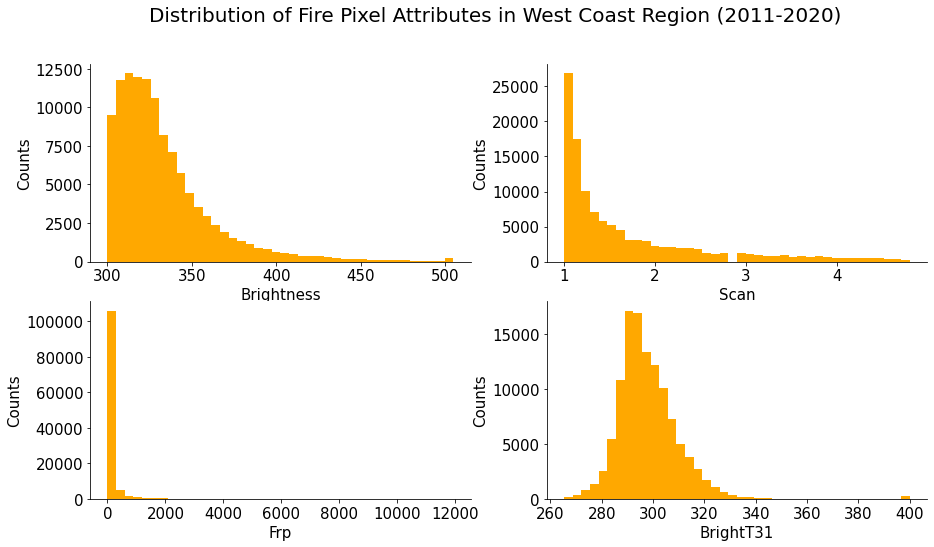

In [23]:
# Specify the features of interest
num_features = ['Brightness', 'Scan', 'Frp', 'BrightT31']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']
histogram(xaxes, yaxes, ca_nasa_df, 15,8, 2, "#ffa800")

In [24]:
geometry = [Point(xy) for xy in zip(ca_nasa_df['NasaLongitude'], ca_nasa_df['NasaLatitude'])]
geometry[:3]

In [25]:
crs = {'init': "EPSG:4326"}
geo_nasa_df = gpd.GeoDataFrame(ca_nasa_df, crs=crs, geometry=geometry)
geo_nasa_df.head(2)

,NasaLatitude,NasaLongitude,Brightness,Scan,Track,ActiveDate,Satellite,Confidence,BrightT31,Frp,DayNight,HotSpotType,ActiveYear,ActiveMonth,ActiveDay,ConfidenceBinned,geometry
26628,34.6033,-118.3848,305.8,1.2,1.1,2011-01-06,Terra,54,279.1,12.8,D,0.0,2011,1,6,nominal,POINT (-118.38480 34.60330)
26638,39.8467,-121.5210,308.2,1.1,1.0,2011-01-07,Terra,74,277.9,13.5,N,0.0,2011,1,7,nominal,POINT (-121.52100 39.84670)


In [26]:
geo_nasa_df = geo_nasa_df.to_crs({'init': "EPSG:3310"})

In [27]:
y = ca_nasa_df[ca_nasa_df['NasaLongitude'] <=-119.5]
z = ca_nasa_df[(ca_nasa_df['NasaLatitude'] <= 39.5) & (ca_nasa_df['NasaLatitude'] >= 36.5)]
w = z[(z['NasaLongitude'] >=-119.5) & (z['NasaLongitude'] <=-116)]
v = ca_nasa_df[ca_nasa_df['NasaLatitude'] <= 36.5]

plot_df = pd.concat([y,z,w,v])
plot_df = plot_df[~((plot_df['NasaLatitude']>39) & (plot_df['NasaLongitude']>-120))]
plot_df = plot_df[~((plot_df['NasaLatitude']>38) & (plot_df['NasaLongitude']>-118.5))]
plot_df = plot_df[~((plot_df['NasaLatitude']>37) & (plot_df['NasaLongitude']>-117))]
plot_df = plot_df[~((plot_df['NasaLatitude']>36) & (plot_df['NasaLongitude']>-116.5))]


geometry = [Point(xy) for xy in zip(plot_df['NasaLongitude'], plot_df['NasaLatitude'])]
geometry[:3]
plot_df = gpd.GeoDataFrame(plot_df, crs=crs, geometry=geometry)

In [28]:
stcode = ['06']

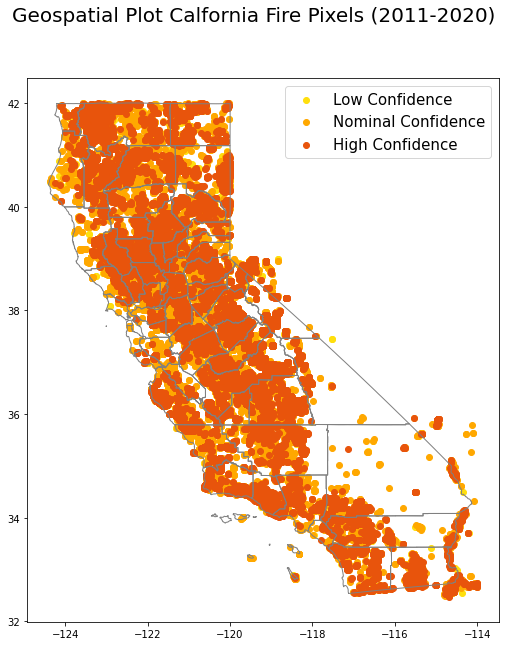

In [29]:
fig, ax = plt.subplots(figsize = (10, 10))
fig.suptitle('Geospatial Plot Calfornia Fire Pixels (2011-2020)', fontsize=20)

plot_df[plot_df['ConfidenceBinned'] == "low"].plot(ax=ax, color="#FFDF0D", label="Low Confidence")
plot_df[plot_df['ConfidenceBinned'] == "nominal"].plot(ax=ax, color="#FFA800", label="Nominal Confidence")
plot_df[plot_df['ConfidenceBinned'] == "high"].plot(ax=ax, color="#E8540C", label="High Confidence")
USA[USA['STATEFP'].isin(stcode)].plot(ax=ax, edgecolor="grey", facecolor="None")
plt.legend(prop={'size':15})

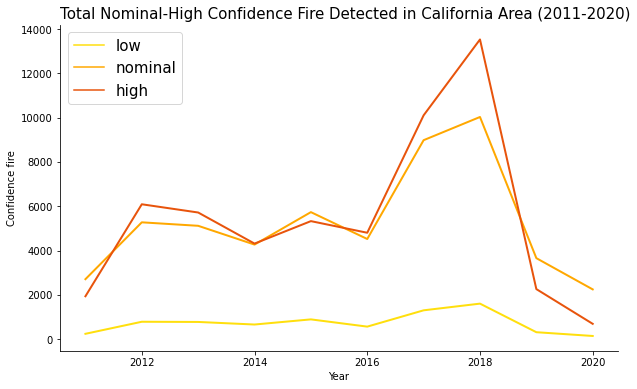

In [30]:
confidence_count = pd.DataFrame(geo_nasa_df[['ConfidenceBinned', 'ActiveYear']].value_counts(sort=False)).reset_index()
confidence_count.columns.values[2] = 'count'
colors = ["#FFDF0D", "#FFA800","#E8540C"]
plt.rcParams['figure.figsize'] = [10,6]
ax = sns.lineplot(data=confidence_count, x="ActiveYear", y='count', hue='ConfidenceBinned', 
                  palette=sns.color_palette(colors), linewidth=2)

ax.set_title("Total Nominal-High Confidence Fire Detected in California Area (2011-2020)",fontsize = 15, loc='left')
ax.set_xlabel("Year")
ax.set_ylabel("Confidence fire")
sns.despine()
plt.legend(prop={'size':15}, loc='upper left')
plt.show()


### What Hotspot Type has the highest confidence for Fire?

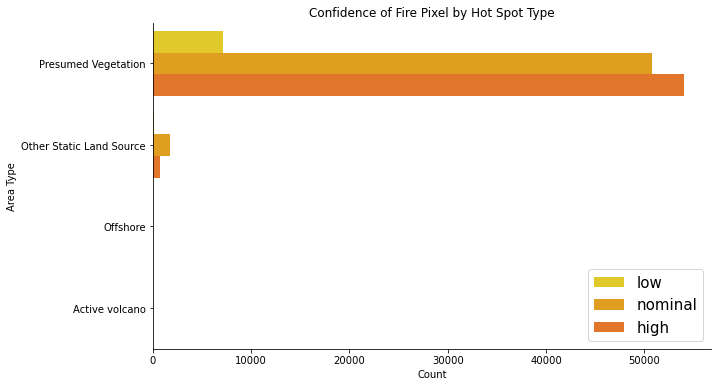

In [31]:
colors = ["#FFDF0D", "#FFA800","#FF710D"]
df1 = geo_nasa_df.replace({'HotSpotType' : {3 : 'Offshore', 2 : 'Other Static Land Source', 
                                         1 : "Active volcano", 0 : "Presumed Vegetation"}})
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = [10,6]
sns.countplot(y=df1['HotSpotType'], data=df1, hue=df1['ConfidenceBinned']).set(title = "Confidence of Fire Pixel by Hot Spot Type", 
                                     xlabel = "Count", ylabel = "Area Type")

sns.despine()
plt.legend(prop={'size':15}, loc='lower right')
plt.show()

### What Month highest fires were detected?

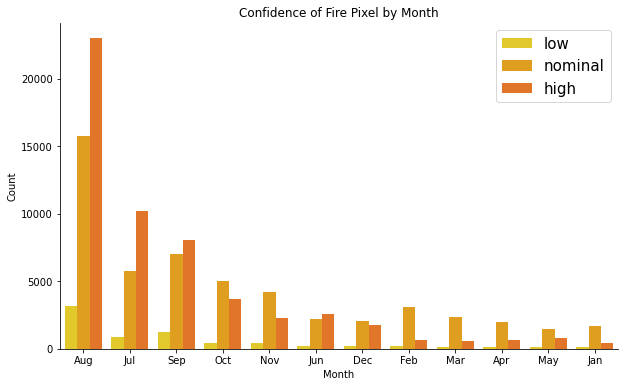

In [32]:
colors = ["#FFDF0D", "#FFA800","#FF710D"]
df1 = geo_nasa_df.replace({'ActiveMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                         5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                         9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = [10,6]
sns.countplot(x=df1['ActiveMonth'], data=df1, hue=df1['ConfidenceBinned'], 
              order=df1['ActiveMonth'].value_counts().index).set(title =  "Confidence of Fire Pixel by Month", 
                                     xlabel = "Month", ylabel = "Count")

sns.despine()
plt.legend(prop={'size':15}, loc='upper right')
plt.show()